In [1]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline

::: {#qft_arithmetics}
Basic arithmetic with the quantum Fourier transform (QFT)
=======================================
:::

::: {.meta}
:property=\"og:description\": Learn how to use the quantum Fourier
transform (QFT) to do basic arithmetic :property=\"og:image\":
<https://pennylane.ai/qml/_static/demonstration_assets//qft_arithmetics_thumbnail.png>
:::

::: {.related}
tutorial\_qubit\_rotation Basis tutorial: qubit rotation
:::

*Author: Guillermo Alonso-Linaje --- Posted: 07 November 2022.*

Arithmetic is a fundamental branch of mathematics that consists of the
study of the main operations with numbers such as addition,
multiplication, subtraction and division. Using arithmetic operations we
can understand the world around us and solve many of our daily tasks.

Arithmetic is crucial for the implementation of any kind of algorithm in
classical computer science, but also in quantum computing. For this
reason, in this demo we are going to show an approach to defining
arithmetic operations on quantum computers. The simplest and most direct
way to achieve this goal is to use the quantum Fourier transform (QFT),
which we will demonstrate on a basic level.

In this demo we will not focus on understanding how the QFT is built, as
we can find a great explanation in the [Xanadu Quantum
Codebook](https://codebook.xanadu.ai/F.1). Instead, we will develop the
intuition for how it works and how we can best take advantage of it.

Motivation
==========

The first question we have to ask ourselves is whether it makes sense to
perform these basic operations on a quantum computer. Is the goal purely
academic or is it really something that is needed in certain algorithms?
Why implement in a quantum computer something that we can do with a
calculator?

When it comes to basic quantum computing algorithms like the
Deustch--Jozsa or Grover\'s algorithm, we might think that we have never
needed to apply any arithmetic operations such as addition or
multiplication. However, the reality is different. When we learn about
these algorithms from an academic point of view, we work with a
ready-made operator that we never have to worry about, the *oracle*.
Unfortunately, in real-world situations, we will have to build this
seemingly magical operator by hand. As an example, let\'s imagine that
we want to use Grover\'s algorithm to search for [magic
squares](https://en.wikipedia.org/wiki/Magic_square). To define the
oracle, which determines whether a solution is valid or not, we must
perform sums over the rows and columns to check that they all have the
same value. Therefore, to create this oracle, we will need to define a
sum operator within the quantum computer.

The second question we face is why we should work with the QFT at all.
There are other procedures that could be used to perform these basic
operations; for example, by imitating the classical algorithm. But, as
we can see in, it has already been proven that the QFT needs fewer
qubits to perform these operations, which is nowadays of vital
importance.

We will organize the demo as follows. Initially, we will talk about the
Fourier basis to give an intuitive idea of how it works, after which we
will address different basic arithmetic operations. Finally, we will
move on to a practical example in which we will factor numbers using
Grover\'s algorithm.

QFT representation \-\-\-\-\-\-\-\-\-\-\-\-\-\-\-\--

To apply the QFT to basic arithmetic operations, our objective now is to
learn how to add, subtract and multiply numbers using quantum devices.
As we are working with qubits, ---which, like bits, can take the values
$0$ or $1$---we will represent the numbers in binary. For the purposes
of this tutorial, we will assume that we are working only with integers.
Therefore, if we have $n$ qubits, we will be able to represent the
numbers from $0$ to $2^n-1$.

The first thing we need to know is PennyLane\'s standard for encoding
numbers in a binary format. A binary number can be represented as a
string of 1s and 0s, which we can represent as the multi-qubit state

$$\vert m \rangle = \vert \overline{q_0q_1...q_{n-1}}\rangle,$$

where the formula to obtain the equivalent decimal number $m$ will be:

$$m= \sum_{i = 0}^{n-1}2^{n-1-i}q_i.$$

Note that $\vert m \rangle$ refers to the basic state generated by the
binary encoding of the number $m$. For instance, the natural number $6$
is represented by the quantum state $\vert 110\rangle,$ since
$\vert 110 \rangle = 1 \cdot 2^2 + 1\cdot 2^1+0\cdot 2^0 = 6$.

Let's see how we would represent all the integers from $0$ to $7$ using
the product state of three qubits, visualized by separate Bloch spheres
for each qubit.

![Representation of integers using a computational basis of three
qubits.](/_static/demonstration_assets/qft_arithmetics/3_qubits_computational_basis.gif){.align-center
width="90.0%"}

::: {.note}
::: {.title}
Note
:::

The [Bloch sphere](https://en.wikipedia.org/wiki/Bloch_sphere) is a way
of graphically representing the state of a qubit. At the top of the
sphere we place the state $\vert 0 \rangle,$ at the bottom
$\vert 1 \rangle$, and in the rest of the sphere we will place the
possible states in superposition. It is a very useful representation
that helps better visualize and interpret quantum gates such as
rotations.
:::

We can use the
`qml.BasisEmbedding <pennylane.BasisEmbedding>`{.interpreted-text
role="class"} template to obtain the binary representation in a simple
way. Let\'s see how we would code the number $6$.


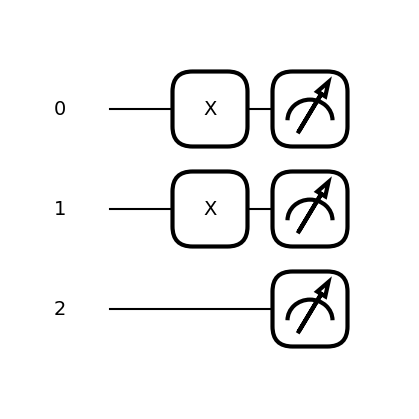

In [2]:
import pennylane as qml
import matplotlib.pyplot as plt

dev = qml.device("default.qubit", wires=3)

@qml.compile
@qml.qnode(dev)
def basis_embedding_circuit(m):
    qml.BasisEmbedding(m, wires=range(3))
    return qml.state()

m = 6 # number to be encoded

qml.draw_mpl(basis_embedding_circuit, show_all_wires=True)(m)
plt.show()

As we can see, the first qubit---the $0$-th wire---is placed on top and
the rest of the qubits are below it. However, this is not the only way
we could represent numbers. We can also represent them in different
bases, such as the so-called *Fourier base*.

In this case, all the states of the basis will be represented via qubits
in the XY-plane of the Bloch sphere, each rotated by a certain amount.

How do we know how much we must rotate each qubit to represent a certain
number? It is actually very easy! Suppose we are working with $n$ qubits
and we want to represent the number $m$ in the Fourier basis. Then the
$j$-th qubit will have the phase:

$$\alpha_j = \frac{2m\pi}{2^{j}}.$$

Now we can represent numbers in the Fourier basis using three qubits:

![Representation of integers using the Fourier basis with three
qubits](/_static/demonstration_assets/qft_arithmetics/3_qubits_fourier_basis.gif){.align-center
width="90.0%"}

As we can see, the third qubit will rotate $\frac{1}{8}$ of a turn
counterclockwise with each number. The next qubit rotates $\frac{1}{4}$
of a full turn and, finally, the first qubit rotates half a turn for
each increase in number.

Adding a number to a register
=============================

The fact that the states encoding the numbers are now in phase gives us
great flexibility in carrying out our arithmetic operations. To see this
in practice, let's look at the situation in which want to create an
operator Sum such that:

$$\text{Sum(k)}\vert m \rangle = \vert m + k \rangle.$$

The procedure to implement this unitary operation is the following:

1.  We convert the state from the computational basis into the Fourier
    basis by applying the QFT to the $\vert m \rangle$ state via the
    `~pennylane.QFT`{.interpreted-text role="class"} operator.
2.  We rotate the $j$-th qubit by the angle $\frac{2k\pi}{2^{j}}$ using
    the $R_Z$ gate, which leads to the new phases,
    $\frac{2(m + k)\pi}{2^{j}}$.
3.  We apply the QFT inverse to return to the computational basis and
    obtain $m+k$.

Let\'s see how this process would look in PennyLane.


In [6]:
import pennylane as qml
import numpy as np

n_wires = 4
dev = qml.device("default.qubit", wires=n_wires, shots=1)

def add_k_fourier(k, wires):
    for j in range(len(wires)):
        qml.RZ(k * np.pi / (2**j), wires=wires[j])

@qml.qnode(dev)
def sum(m, k):
    qml.BasisEmbedding(m, wires=range(n_wires))

    #step 1
    qml.QFT(wires=range(n_wires))
    #step 2
    add_k_fourier(k, range(n_wires))
    #step 3
    qml.adjoint(qml.QFT)(wires=range(n_wires))

    return qml.sample()

print(f"The ket representation of the sum of 3 and 4 is {sum(3,4)}")

The ket representation of the sum of 3 and 4 is [0 1 1 1]


Perfect, we have obtained $\vert 0111 \rangle$, which is equivalent to
the number $7$ in binary!

Note that this is a deterministic algorithm, which means that we have
obtained the desired solution by executing a single shot. On the other
hand, if the result of an operation is greater than the maximum value
$2^n-1$, we will start again from zero, that is to say, we will
calculate the sum modulo $2^n-1.$ For instance, in our three-qubit
example, suppose that we want to calculate $6+3.$ We see that we do not
have enough memory space, as $6+3 = 9 > 2^3-1$. The result we will get
will be $9 \pmod 8 = 1$, or $\vert 001 \rangle$ in binary. Make sure to
use enough qubits to represent your solutions! Finally, it is important
to point out that it is not necessary to know how the QFT is constructed
in order to use it. By knowing the properties of the new basis, we can
use it in a simple way.

Adding two different registers
==============================

In this previous algorithm, we had to pass to the operator the value of
$k$ that we wanted to add to the starting state. But at other times,
instead of passing that value to the operator, we would like it to pull
the information from another register. That is, we are looking for a new
operator $\text{Sum}_2$ such that

$$\text{Sum}_2\vert m \rangle \vert k \rangle \vert 0 \rangle = \vert m \rangle \vert k \rangle \vert m+k \rangle.$$

In this case, we can understand the third register (which is initially
at $0$) as a counter that will tally as many units as $m$ and $k$
combined. The binary decomposition will make this simple. If we have
$\vert m \rangle = \vert \overline{q_0q_1q_2} \rangle$, we will have to
add $1$ to the counter if $q_2 = 1$ and nothing otherwise. In general,
we should add $2^{n-i-1}$ units if the $i$-th qubit is in state
$\vert 1 \rangle$ and 0 otherwise. As we can see, this is the same idea
that is also behind the concept of a controlled gate. Indeed, observe
that we will, indeed, apply a corresponding phase if indeed the control
qubit is in the state $\vert 1\rangle$. Let us now code the
$\text{Sum}_2$ operator.


The ket representation of the sum of 7 and 3 is [1 0 1 0]


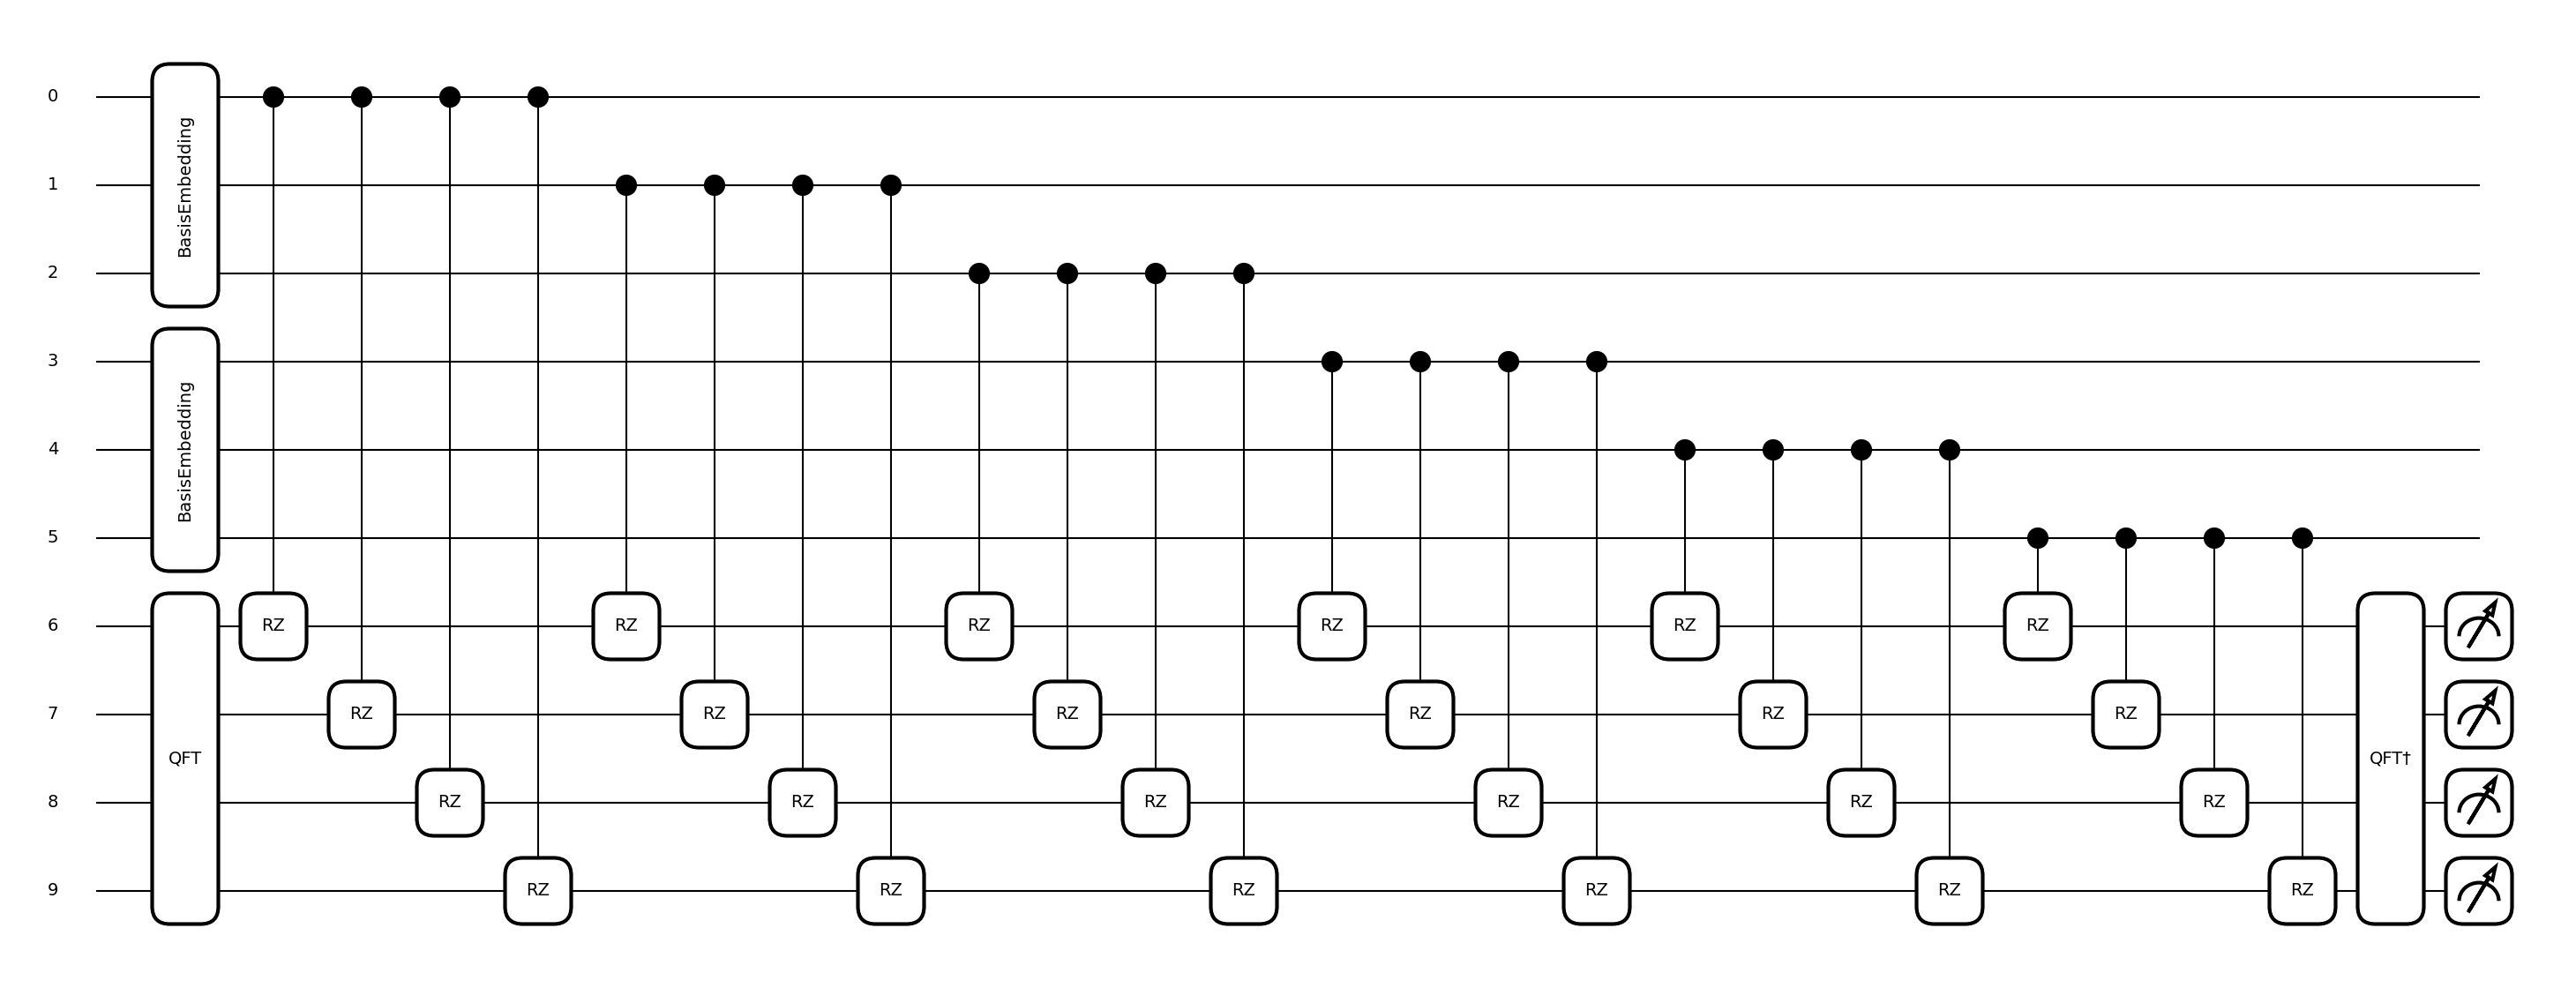

In [7]:
wires_m = [0, 1, 2]             # qubits needed to encode m
wires_k = [3, 4, 5]             # qubits needed to encode k
wires_solution = [6, 7, 8, 9]   # qubits needed to encode the solution

dev = qml.device("default.qubit", wires=wires_m + wires_k + wires_solution, shots=1)

n_wires = len(dev.wires) # total number of qubits used

def addition(wires_m, wires_k, wires_solution):
    # prepare solution qubits to counting
    qml.QFT(wires=wires_solution)

    # add m to the counter
    for i in range(len(wires_m)):
        qml.ctrl(add_k_fourier, control=wires_m[i])(2 **(len(wires_m) - i - 1), wires_solution)

    # add k to the counter
    for i in range(len(wires_k)):
        qml.ctrl(add_k_fourier, control=wires_k[i])(2 **(len(wires_k) - i - 1), wires_solution)

    # return to computational basis
    qml.adjoint(qml.QFT)(wires=wires_solution)

@qml.qnode(dev)
def sum2(m, k, wires_m, wires_k, wires_solution):
    # m and k codification
    qml.BasisEmbedding(m, wires=wires_m)
    qml.BasisEmbedding(k, wires=wires_k)

    # apply the addition circuit
    addition(wires_m, wires_k, wires_solution)

    return qml.sample(wires=wires_solution)

print(f"The ket representation of the sum of 7 and 3 is "
      f"{sum2(7, 3, wires_m, wires_k, wires_solution)}")

qml.draw_mpl(sum2, show_all_wires=True)(7, 3, wires_m, wires_k, wires_solution)
plt.show()

Great! We have just seen how to add a number to a counter. In the
example above, we added $3 + 7$ to get $10$, which in binary is
$\vert 1010 \rangle$.

Multiplying qubits
==================

Following the same idea, we will see how easily we can implement
multiplication. For this purpose we\'ll take two arbitrary numbers $m$
and $k$ to carry out the operation. This time, we look for an operator
Mul such that

$$\text{Mul}\vert m \rangle \vert k \rangle \vert 0 \rangle = \vert m \rangle \vert k \rangle \vert m\cdot k \rangle.$$

To understand the multiplication process, let\'s work with the binary
decomposition of $k:=\sum_{i=0}^{n-1}2^{n-i-1}k_i$ and
$m:=\sum_{j=0}^{l-1}2^{l-j-1}m_i$. In this case, the product would be:

$$k \cdot m = \sum_{i=0}^{n-1}\sum_{j = 0}^{l-1}m_ik_i (2^{n-i-1} \cdot 2^{l-j-1}).$$

In other words, if $k_i = 1$ and $m_i = 1$, we would add
$2^{n-i-1} \cdot 2^{l-j-1}$ units to the counter, where $n$ and $l$ are
the number of qubits with which we encode $m$ and $k$ respectively.
Let\'s code to see how it works!


The ket representation of the multiplication of 3 and 7 is [1 0 1 0 1]


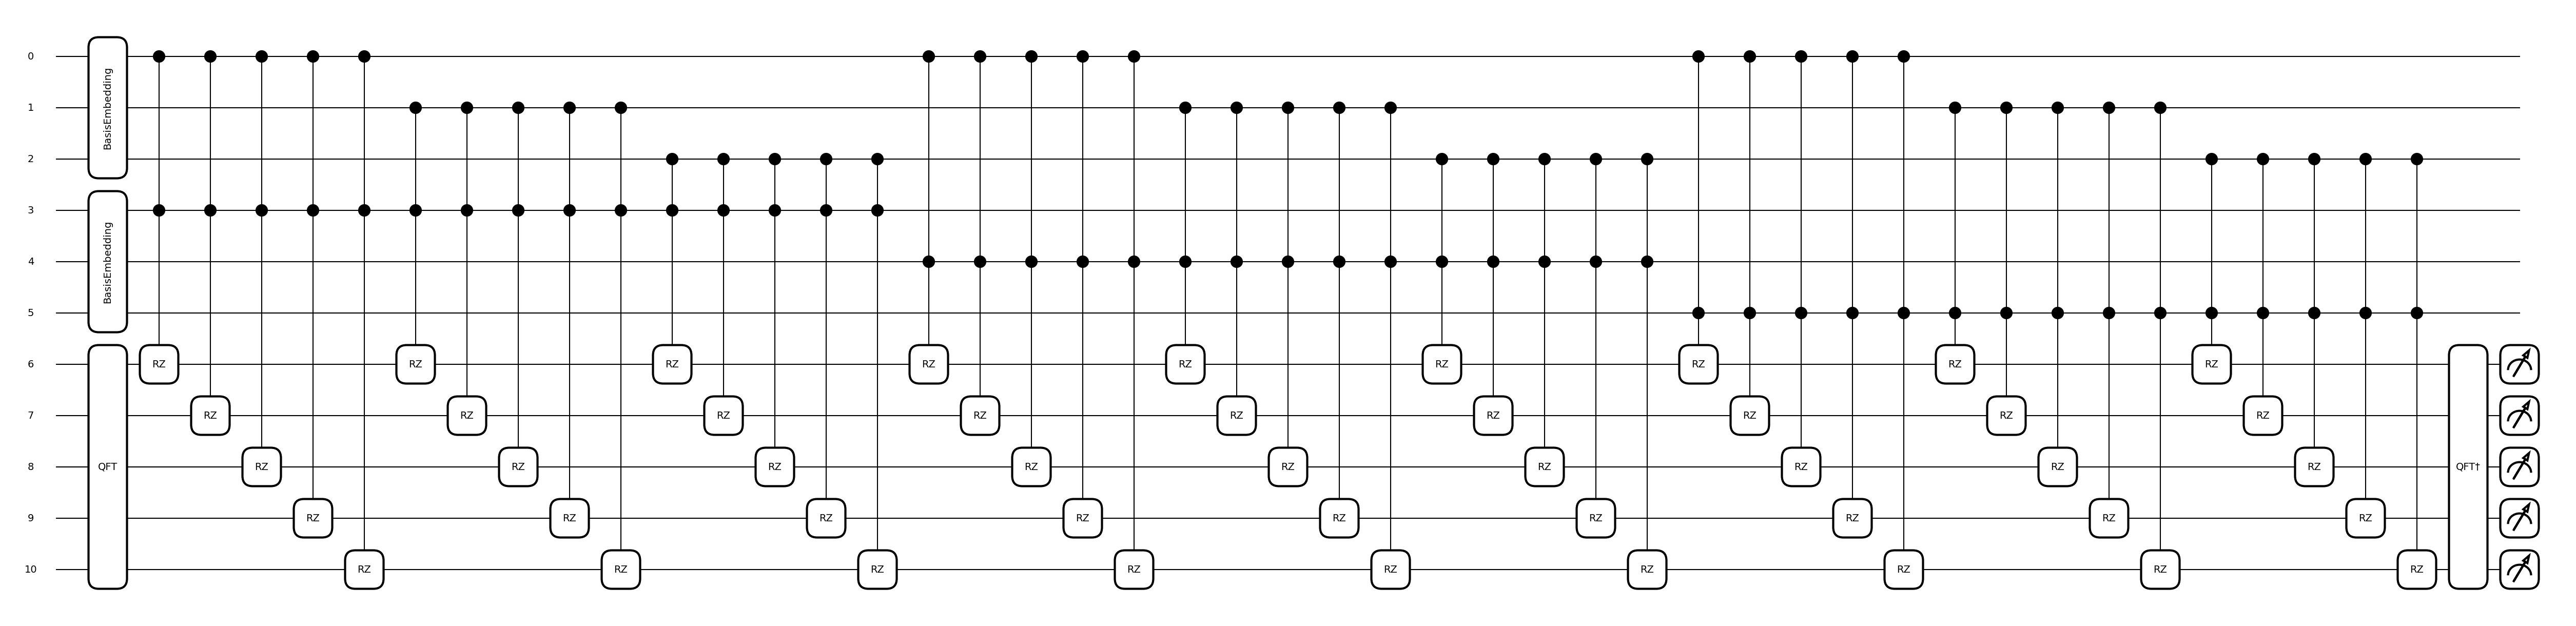

In [8]:
wires_m = [0, 1, 2]           # qubits needed to encode m
wires_k = [3, 4, 5]           # qubits needed to encode k
wires_solution = [6, 7, 8, 9, 10]  # qubits needed to encode the solution

dev = qml.device("default.qubit", wires=wires_m + wires_k + wires_solution, shots=1)

n_wires = len(dev.wires)

def multiplication(wires_m, wires_k, wires_solution):
    # prepare sol-qubits to counting
    qml.QFT(wires=wires_solution)

    # add m to the counter
    for i in range(len(wires_k)):
        for j in range(len(wires_m)):
            coeff = 2 ** (len(wires_m) + len(wires_k) - i - j - 2)
            qml.ctrl(add_k_fourier, control=[wires_k[i], wires_m[j]])(coeff, wires_solution)

    # return to computational basis
    qml.adjoint(qml.QFT)(wires=wires_solution)

@qml.qnode(dev)
def mul(m, k):
    # m and k codification
    qml.BasisEmbedding(m, wires=wires_m)
    qml.BasisEmbedding(k, wires=wires_k)

    # Apply multiplication
    multiplication(wires_m, wires_k, wires_solution)

    return qml.sample(wires=wires_solution)


print(f"The ket representation of the multiplication of 3 and 7 is {mul(3,7)}")

qml.draw_mpl(mul, show_all_wires=True)(3, 7)
plt.show()

Awesome! We have multiplied $7 \cdot 3$ and, as a result, we have
$\vert 10101 \rangle$, which is $21$ in binary.

Factorization with Grover
=========================

With this, we have already gained a large repertoire of interesting
operations that we can do, but we can give the idea one more twist and
apply what we have learned in an example.

Let's imagine now that we want just the opposite: to factor the number
$21$ as a product of two terms. Is this something we could do using our
previous reasoning? The answer is yes! We can make use of [Grover\'s
algorithm](https://en.wikipedia.org/wiki/Grover%27s_algorithm) to
amplify the states whose product is the number we are looking for. All
we would need is to construct the oracle $U$, i.e., an operator such
that

$$U\vert m \rangle \vert k \rangle = \vert m \rangle \vert k \rangle \text{ if }m\cdot k \not = 21,$$

$$U\vert m \rangle \vert k \rangle = -\vert m \rangle \vert k \rangle \text{ if }m\cdot k  = 21$$

The idea of the oracle is as simple as this:

1.  use auxiliary registers to store the product,
2.  check if the product state is $\vert 10101 \rangle$ and, in that
    case, change the sign,
3.  execute the inverse of the circuit to clear the auxiliary qubits.
4.  calculate the probabilities and see which states have been
    amplified.

Let\'s go back to PennyLane to implement this idea.


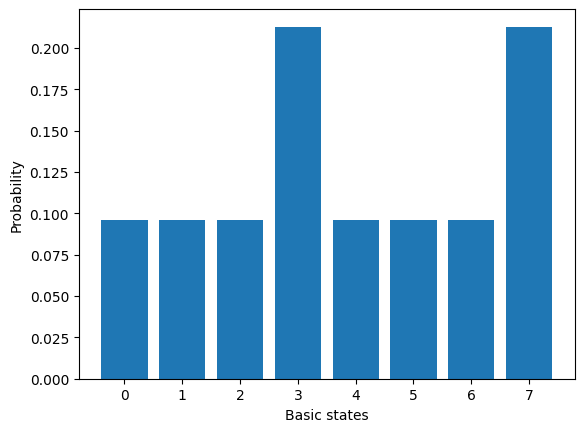

In [14]:
n = 21 # number we want to factor

wires_m = [0, 1, 2]                 # qubits needed to encode m
wires_k = [3, 4, 5]                 # qubits needed to encode k
wires_solution = [6, 7, 8, 9, 10]   # qubits needed to encode the solution

dev = qml.device("default.qubit", wires=wires_m + wires_k + wires_solution)

n_wires = len(dev.wires)

@qml.qnode(dev)
def factorization(n, wires_m, wires_k, wires_solution):
    # Superposition of the input
    for wire in wires_m:
        qml.Hadamard(wires=wire)

    for wire in wires_k:
        qml.Hadamard(wires=wire)

    # Apply the multiplication
    multiplication(wires_m, wires_k, wires_solution)

    # Change sign of n
    qml.FlipSign(n, wires=wires_solution)

    # Uncompute multiplication
    qml.adjoint(multiplication)(wires_m, wires_k, wires_solution)

    # Apply Grover operator
    qml.GroverOperator(wires=wires_m + wires_k)

    return qml.probs(wires=wires_m)


plt.bar(range(2 ** len(wires_m)), factorization(n, wires_m, wires_k, wires_solution))
plt.xlabel("Basic states")
plt.ylabel("Probability")
plt.show()

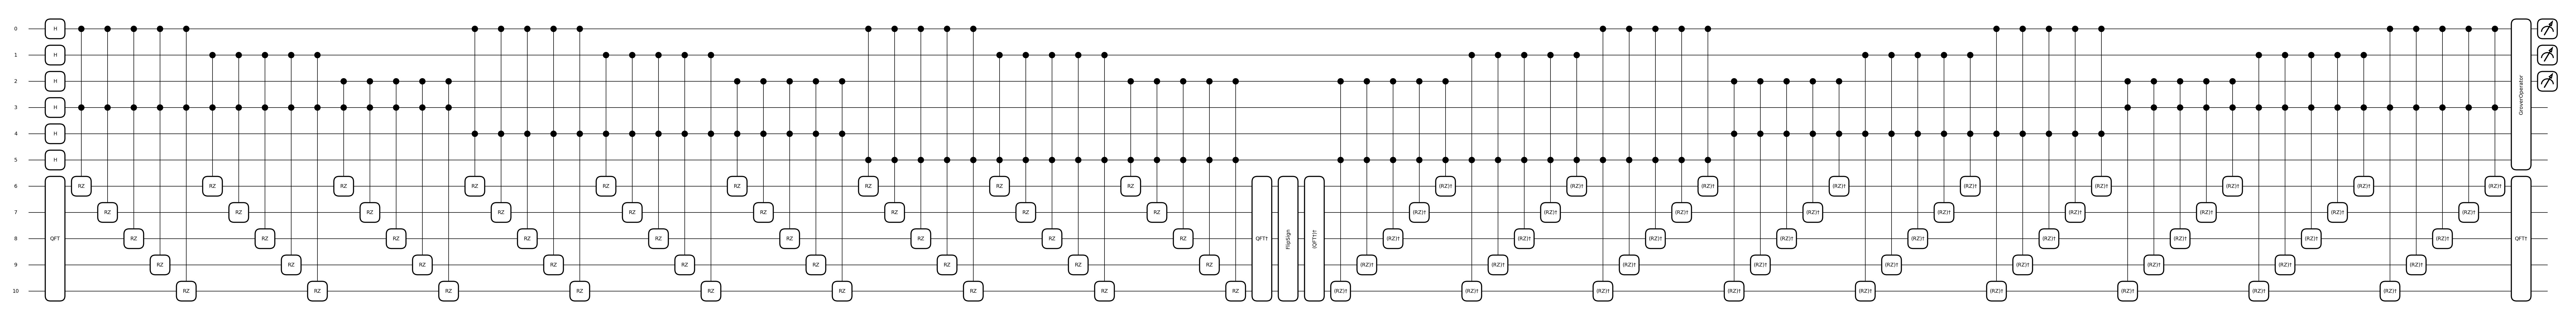

In [10]:
qml.draw_mpl(factorization, show_all_wires=True)(n, wires_m, wires_k, wires_solution)
plt.show()

By plotting the probabilities of obtaining each basic state we see that
prime factors have been amplified! Factorization via Grover's algorithm
does not achieve exponential improvement that [Shor\'s
algorithm](https://en.wikipedia.org/wiki/Shor%27s_algorithm) does, but
we can see that this construction is simple and a great example to
illustrate basic arithmetic!

I hope we can now all see that oracles are not something magical and
that there is a lot of work behind their construction! This will help us
in the future to build more complicated operators, but until then, let's
keep on learning. 🚀

References
==========

About the author
================
